In [ ]:
import numpy as np
from os import listdir

import os
import h5py
import cv2
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import glob
import warnings
from skimage.feature import local_binary_pattern
# To calculate a normalized histogram 
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize
# To read class from file
import csv
from sklearn.model_selection import train_test_split, cross_val_score

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
directory_root = "/content/gdrive/My Drive/rice_leaf_disease/PlantVillage/"

In [ ]:
default_image_size = tuple((256, 256))
bins=8
h5_data          = 'data.h5'
h5_labels        = 'labels.h5'
num_trees = 100
test_size = 0.10
seed      = 9

h5_data    = 'data.h5'
h5_labels  = 'labels.h5'
scoring    = "accuracy"

In [ ]:
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [ ]:
import cv2, numpy

# feature-descriptor-1: Hu Moments(shape)
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
def LBP(image):
    # List for storing the LBP Histograms, address of images and the corresponding label 
                X_test = []
               
            # For each image in the training set calculate the LBP histogram
            # and update X_test, X_name and y_test
                # Read the image
                im = cv2.imread(image)
                # Convert to grayscale as LBP works on grayscale image
                im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                radius = 3
                # Number of points to be considered as neighbourers 
                no_points = 8 * radius
                # Uniform LBP is used
                lbp = local_binary_pattern(im_gray, no_points, radius, method='uniform')
                # Calculate the histogram
                x = itemfreq(lbp.ravel())
                # Normalize the histogram
                hist = x[:, 1]/sum(x[:, 1])
                X_test.append(hist)
                x_test=np.array(X_test)
                return x_test.flatten()

In [ ]:
fixed_size = tuple((500, 500))
label_list = []
image_list=[]
global_features = []
labels          = []
print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for plant_folder in root_dir :
    plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
        for image in plant_disease_image_list:
            image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
            
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image = cv2.imread(image_directory )
                    image = cv2.resize(image, fixed_size)
                    fv_hu_moments = fd_hu_moments(image)
                    fv_histogram  = fd_histogram(image)
                    fv_texture=LBP(image_directory)
    
                    global_feature = np.hstack([fv_histogram, fv_hu_moments,fv_texture])
                    global_features.append(global_feature)
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
        print("[INFO] Image loading completed")  

[INFO] Loading images ...
[INFO] Processing Pepper__bell___healthy ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


[INFO] Image loading completed
[INFO] Processing Potato___Early_blight ...
[INFO] Image loading completed
[INFO] Processing Potato___Late_blight ...
[INFO] Image loading completed
[INFO] Processing Tomato__Target_Spot ...
[INFO] Image loading completed
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Image loading completed
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Image loading completed
[INFO] Processing Tomato_Early_blight ...
[INFO] Image loading completed
[INFO] Processing Tomato_Late_blight ...
[INFO] Image loading completed
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Image loading completed


In [ ]:
 # encode the target labels
targetNames = np.unique(label_list)
le          = LabelEncoder()
target      = le.fit_transform(label_list)
print("[STATUS] training labels encoded...")

NameError: ignored

In [ ]:
# scale features in the range (0-1)
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")


[STATUS] feature vector normalized...


In [ ]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] end of training..


In [ ]:
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] target labels shape: (15236,)


In [ ]:
image_size = len(image_list)
print(image_size)

15236


In [ ]:
image_list[:5]

[array([[[118., 105., 113.],
         [120., 107., 115.],
         [123., 110., 118.],
         ...,
         [112., 102., 114.],
         [119., 109., 121.],
         [107.,  97., 109.]],
 
        [[136., 123., 131.],
         [136., 123., 131.],
         [135., 122., 130.],
         ...,
         [131., 121., 133.],
         [132., 122., 134.],
         [107.,  97., 109.]],
 
        [[121., 108., 116.],
         [121., 108., 116.],
         [120., 107., 115.],
         ...,
         [109.,  99., 111.],
         [109.,  99., 111.],
         [118., 108., 120.]],
 
        ...,
 
        [[194., 187., 192.],
         [192., 185., 190.],
         [189., 182., 187.],
         ...,
         [183., 179., 185.],
         [183., 179., 185.],
         [183., 179., 185.]],
 
        [[195., 188., 193.],
         [193., 186., 191.],
         [191., 184., 189.],
         ...,
         [177., 173., 179.],
         [179., 175., 181.],
         [180., 176., 182.]],
 
        [[195., 188., 193.],
 

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='sigmoid'),
   
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(11, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [ ]:
# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

[STATUS] features shape: (15236, 545)
[STATUS] labels shape: (15236,)


In [ ]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (13712, 545)
Test data   : (1524, 545)
Train labels: (13712,)
Test labels : (1524,)


In [ ]:
model.fit(trainDataGlobal, trainLabelsGlobal,epochs=20)


Epoch 1/20
13712/13712 [==============================] - 2s 168us/step - loss: 1.4119 - accuracy: 0.5005
Epoch 2/20
13712/13712 [==============================] - 2s 124us/step - loss: 0.6250 - accuracy: 0.7931
Epoch 3/20
13712/13712 [==============================] - 2s 121us/step - loss: 0.3865 - accuracy: 0.8766
Epoch 4/20
13712/13712 [==============================] - 2s 122us/step - loss: 0.2776 - accuracy: 0.9134
Epoch 5/20
13712/13712 [==============================] - 2s 123us/step - loss: 0.2157 - accuracy: 0.9333
Epoch 6/20
13712/13712 [==============================] - 2s 123us/step - loss: 0.1673 - accuracy: 0.9483
Epoch 7/20
13712/13712 [==============================] - 2s 123us/step - loss: 0.1482 - accuracy: 0.9529
Epoch 8/20
13712/13712 [==============================] - 2s 120us/step - loss: 0.1252 - accuracy: 0.9623
Epoch 9/20
13712/13712 [==============================] - 2s 123us/step - loss: 0.1075 - accuracy: 0.9651
Epoch 10/20
13712/13712 [=====================

In [ ]:
model.save("/content/gdrive/My Drive/rice_leaf_disease/PlantVillage.h5")

NameError: ignored

In [ ]:
train_labels=['tomato_yellowleaf_curls','tomato_targetspot','tomato_spider_mites_spotte','tomato_mosiacvirus','tomato_leafblight','tomato_earlyblight','tomato_bacterialspot','potato_leafblight',
              'potato_earlyblight','pepper_bellhealthy']

In [ ]:
def predict_disease(file):
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)
        fv_hu_moments = fd_hu_moments(image)
        fv_histogram  = fd_histogram(image)
        fv_texture=LBP(file)
        global_feature = np.hstack([fv_histogram,fv_hu_moments,fv_texture]).reshape(-1,1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        rescaled_feature = scaler.fit_transform(global_feature)
        prediction = model.predict(rescaled_feature.reshape(1,-1))[0]  
        print(prediction)
        p=np.argmax(prediction)
        print(p)
        cv2.putText(image,train_labels[p], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,0,255), 3)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  

In [ ]:
file="/content/gdrive/My Drive/rice_leaf_disease/leafblight_potato.JPG"
predict_disease(file)      

NameError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


[4.2498494e-03 4.4974931e-05 1.2485249e-03 2.2205288e-06 5.1903276e-06
 2.1137532e-06 7.0826123e-03 7.3410362e-02 2.0709451e-06 9.1395181e-01
 2.7541356e-07]
9


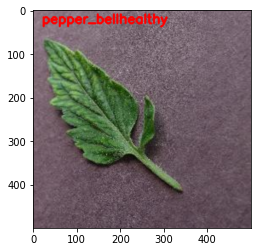

In [ ]:
file="/content/gdrive/My Drive/rice_leaf_disease/tomato_mosiacvirus.JPG"
predict_disease(file)      